# Replicating and Extending Thistlewaite and Campbell (1960) Regression Discontinuity Analysis

## Introduction

This notebook aims to replicate key findings from the seminal paper by Thistlewaite and Campbell (1960), "Regression-Discontinuity Analysis: An Alternative to the Ex Post Facto Experiment." This paper introduced the Regression Discontinuity Design (RDD) methodology.

We will use aggregated data derived from the original study, focusing on the effect of receiving a Certificate of Merit (C of M) based on a qualifying test score on subsequent student outcomes. The C of M was awarded to students scoring above a certain threshold on the Scholarship Qualifying Test (SQT), creating a natural experiment setup ideal for RDD.

**Objective:**

1.  **Replicate Figures 2 and 3** from the paper, showing the relationship between the aptitude test score (running variable) and:
    *   Percentage winning scholarships (any amount and $150+).
    *   Percentage planning advanced graduate study or specific careers (teacher/researcher).
2.  **Extend the Analysis:** Estimate the causal effect of receiving the Certificate of Merit (the discontinuity at the cutoff) on these outcomes using RDD, including point estimates and 95% confidence intervals.
3.  **Visualize the Extended Results:** Re-plot Figures 2 and 3, incorporating the estimated treatment effects and confidence intervals.

**Data:**

The data (`Merits_scholarship.csv`) is aggregated, meaning each row represents a group of students within a specific test score bin relative to their state's cutoff. Key variables include:
*   `test_score`: The aptitude score bin (1-10 for Commended Students, 11-20 for C of M winners). The cutoff is between 10 and 11.
*   `certificate_of_merit`: Indicator for C of M winners (implicitly defined by `test_score > 10.5`).
*   `number_respondents`: The number of students in each bin who responded to the survey (used as weights).
*   Outcome variables (percentages): `scholarship`, `scholarship_150`, `graduate_study`, `teacher_researcher`.

**Methodology:**

We will use Weighted Least Squares (WLS) regression, weighted by `number_respondents`, to account for the aggregated nature of the data. We will fit separate regression lines for students below and above the cutoff to replicate the original figures. For the RDD estimation, we will fit a local linear regression model around the cutoff to estimate the treatment effect (the jump in the outcome variable at the cutoff).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

## Load and Prepare Data

First, we load the dataset `Merits_scholarship.csv`. Then, we perform essential data cleaning and preparation steps:

1.  **Handle Missing/Irrelevant Rows:** The first and last rows contain summary information or undefined test scores ('< 1', '> 20') and missing outcome data, so we'll drop them.
2.  **Convert `test_score` to Numeric:** Ensure the test score is treated as a number.
3.  **Define the Running Variable:** The `test_score` is our running variable. For RDD analysis, it's conventional to center the running variable around the cutoff. The cutoff lies between scores 10 and 11. We define a centered score `score_c` such that the cutoff is at 0. `score_c = test_score - 10.5`.
4.  **Define the Treatment Variable:** Create a binary indicator variable `treatment` which is 1 if the student received the Certificate of Merit (`test_score >= 11` or `score_c > 0`) and 0 otherwise.
5.  **Define Weights:** Use `number_respondents` as weights for our regression analyses, as the data is aggregated.
6.  **Check Data:** Display the first few rows and data types to ensure everything is loaded correctly.

In [2]:
# Load the dataset
try:
    df = pd.read_csv("CampbellThistlewaite1960.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Merits_scholarship.csv not found. Make sure the file is in the root folder.")
    # You might want to stop execution here or handle the error appropriately
    exit() # Or raise an exception

# Drop rows with non-numeric test scores or missing outcome data
# These are typically the first ('< 1') and last ('> 20') rows in this dataset
df = df[pd.to_numeric(df['test_score'], errors='coerce').notna()]

# Convert test_score to integer
df['test_score'] = df['test_score'].astype(int)

# Define the centered running variable (cutoff is between 10 and 11, so center at 10.5)
df['score_c'] = df['test_score'] - 10.5

# Define the treatment variable (1 if score >= 11, 0 otherwise)
df['treatment'] = (df['score_c'] > 0).astype(int)

# Define weights
df['weights'] = df['number_respondents']

# Drop rows with missing weights or zero weights if any
df = df.dropna(subset=['weights'])
df = df[df['weights'] > 0]

# Display data info and first few rows
print("\nData Information:")
df.info()
print("\nFirst 5 rows of prepared data:")
print(df.head())
print("\nLast 5 rows of prepared data:")
print(df.tail())

Data loaded successfully.

Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 1 to 20
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   certificate_of_merit  20 non-null     int64  
 1   test_score            20 non-null     int64  
 2   merit_scholars        10 non-null     float64
 3   number_in_sample      20 non-null     int64  
 4   number_respondents    20 non-null     int64  
 5   scholarship           20 non-null     float64
 6   scholarship_150       20 non-null     float64
 7   graduate_study        20 non-null     float64
 8   teacher_researcher    20 non-null     float64
 9   intellectualism       20 non-null     float64
 10  score_c               20 non-null     float64
 11  treatment             20 non-null     int64  
 12  weights               20 non-null     int64  
dtypes: float64(7), int64(6)
memory usage: 2.2 KB

First 5 rows of prepared data:
   certifi

## Replicating Figure 2: Scholarship Outcomes

Now we replicate Figure 2 from Thistlewaite and Campbell (1960). This figure shows the percentage of students winning any scholarship (`scholarship`) and scholarships of $150 or more (`scholarship_150`) against their aptitude test score.

We will:
1.  Plot the raw data points for both outcomes, distinguishing between Commended Students (`treatment == 0`) and Certificate of Merit Winners (`treatment == 1`).
2.  Fit separate weighted linear regression lines for each group (below and above the cutoff) for both outcomes.
3.  Add these regression lines to the plot.
4.  Add a vertical line at the cutoff point (`score_c = 0` or `test_score = 10.5`).
5.  Label the plot appropriately to match the original figure's style.

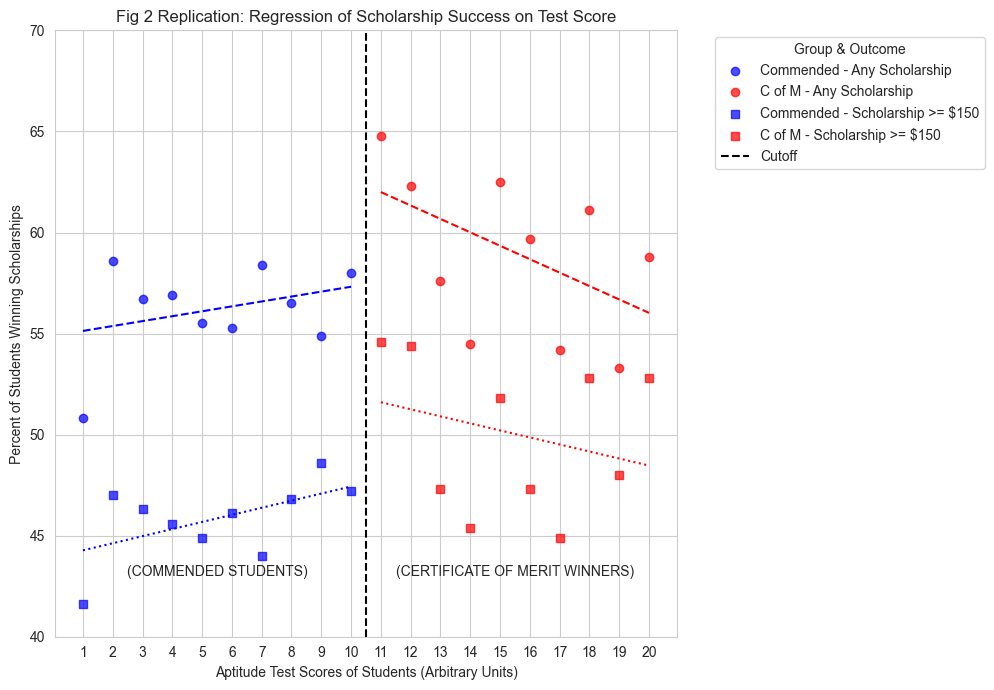

In [3]:
# Separate data for treatment and control groups
df_control = df[df['treatment'] == 0].copy()
df_treated = df[df['treatment'] == 1].copy()

# --- Plot for 'scholarship' (Any Scholarship) ---

# Fit WLS models for scholarship ~ score_c for each group
model_schol_control = smf.wls('scholarship ~ score_c', data=df_control, weights=df_control['weights']).fit()
model_schol_treated = smf.wls('scholarship ~ score_c', data=df_treated, weights=df_treated['weights']).fit()

# Generate predictions for the regression lines
df_control['pred_schol'] = model_schol_control.predict(df_control)
df_treated['pred_schol'] = model_schol_treated.predict(df_treated)

# --- Plot for 'scholarship_150' ($150 or More) ---

# Fit WLS models for scholarship_150 ~ score_c for each group
model_schol150_control = smf.wls('scholarship_150 ~ score_c', data=df_control, weights=df_control['weights']).fit()
model_schol150_treated = smf.wls('scholarship_150 ~ score_c', data=df_treated, weights=df_treated['weights']).fit()

# Generate predictions for the regression lines
df_control['pred_schol150'] = model_schol150_control.predict(df_control)
df_treated['pred_schol150'] = model_schol150_treated.predict(df_treated)


# --- Create the Plot (Replication of Figure 2) ---
plt.figure(figsize=(12, 7))

# Plot raw data points
plt.scatter(df_control['test_score'], df_control['scholarship'], color='blue', alpha=0.7, label='Commended - Any Scholarship')
plt.scatter(df_treated['test_score'], df_treated['scholarship'], color='red', alpha=0.7, label='C of M - Any Scholarship')
plt.scatter(df_control['test_score'], df_control['scholarship_150'], marker='s', color='blue', alpha=0.7, label='Commended - Scholarship >= $150')
plt.scatter(df_treated['test_score'], df_treated['scholarship_150'], marker='s', color='red', alpha=0.7, label='C of M - Scholarship >= $150')

# Plot regression lines
plt.plot(df_control['test_score'], df_control['pred_schol'], color='blue', linestyle='--')
plt.plot(df_treated['test_score'], df_treated['pred_schol'], color='red', linestyle='--')
plt.plot(df_control['test_score'], df_control['pred_schol150'], color='blue', linestyle=':')
plt.plot(df_treated['test_score'], df_treated['pred_schol150'], color='red', linestyle=':')

# Add cutoff line
plt.axvline(x=10.5, color='black', linestyle='--', label='Cutoff')

# Labels and Title
plt.xlabel("Aptitude Test Scores of Students (Arbitrary Units)")
plt.ylabel("Percent of Students Winning Scholarships")
plt.title("Fig 2 Replication: Regression of Scholarship Success on Test Score")
plt.ylim(40, 70) # Match approximate y-axis limits from original figure
plt.xticks(range(1, 21)) # Match x-axis ticks
plt.legend(title="Group & Outcome", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.text(5.5, 43, "(COMMENDED STUDENTS)", horizontalalignment='center')
plt.text(15.5, 43, "(CERTIFICATE OF MERIT WINNERS)", horizontalalignment='center')
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()

## Replicating Figure 3: Study and Career Plans

Next, we replicate Figure 3, which shows the percentage of students planning extensive graduate study (`graduate_study`) and those planning careers as college teachers or scientific researchers (`teacher_researcher`).

The process is analogous to replicating Figure 2: plot raw data, fit separate WLS lines for treated and control groups for each outcome, and add the lines and cutoff indicator to the plot.

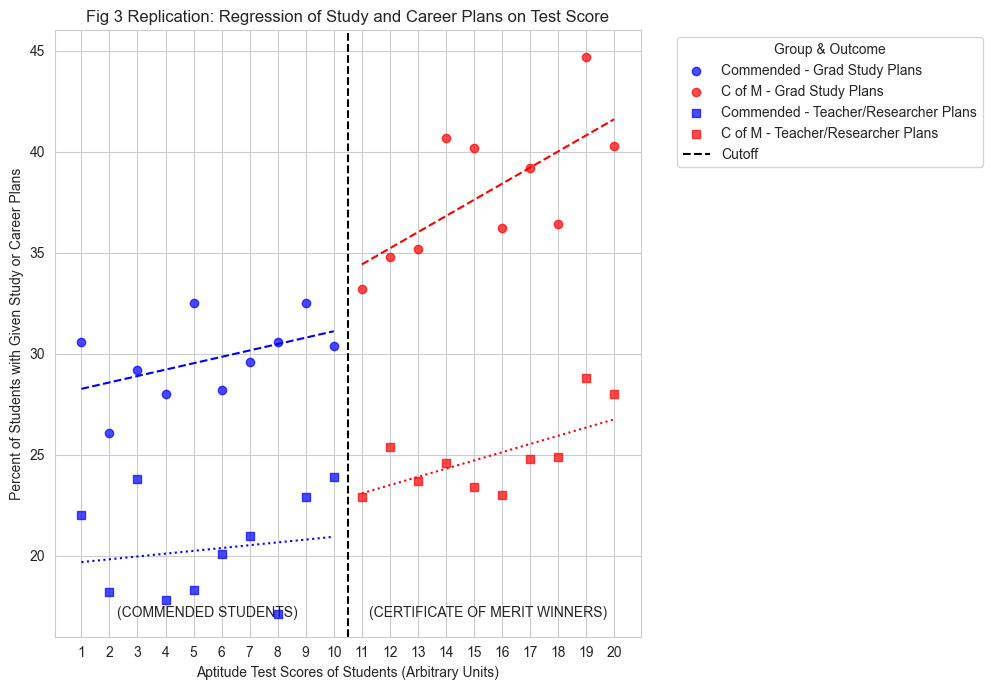

In [4]:
# --- Plot for 'graduate_study' (PhD or MD plans) ---

# Fit WLS models for graduate_study ~ score_c for each group
model_grad_control = smf.wls('graduate_study ~ score_c', data=df_control, weights=df_control['weights']).fit()
model_grad_treated = smf.wls('graduate_study ~ score_c', data=df_treated, weights=df_treated['weights']).fit()

# Generate predictions for the regression lines
df_control['pred_grad'] = model_grad_control.predict(df_control)
df_treated['pred_grad'] = model_grad_treated.predict(df_treated)

# --- Plot for 'teacher_researcher' (Career plans) ---

# Fit WLS models for teacher_researcher ~ score_c for each group
model_teach_control = smf.wls('teacher_researcher ~ score_c', data=df_control, weights=df_control['weights']).fit()
model_teach_treated = smf.wls('teacher_researcher ~ score_c', data=df_treated, weights=df_treated['weights']).fit()

# Generate predictions for the regression lines
df_control['pred_teach'] = model_teach_control.predict(df_control)
df_treated['pred_teach'] = model_teach_treated.predict(df_treated)


# --- Create the Plot (Replication of Figure 3) ---
plt.figure(figsize=(12, 7))

# Plot raw data points
plt.scatter(df_control['test_score'], df_control['graduate_study'], color='blue', alpha=0.7, label='Commended - Grad Study Plans')
plt.scatter(df_treated['test_score'], df_treated['graduate_study'], color='red', alpha=0.7, label='C of M - Grad Study Plans')
plt.scatter(df_control['test_score'], df_control['teacher_researcher'], marker='s', color='blue', alpha=0.7, label='Commended - Teacher/Researcher Plans')
plt.scatter(df_treated['test_score'], df_treated['teacher_researcher'], marker='s', color='red', alpha=0.7, label='C of M - Teacher/Researcher Plans')

# Plot regression lines
plt.plot(df_control['test_score'], df_control['pred_grad'], color='blue', linestyle='--')
plt.plot(df_treated['test_score'], df_treated['pred_grad'], color='red', linestyle='--')
plt.plot(df_control['test_score'], df_control['pred_teach'], color='blue', linestyle=':')
plt.plot(df_treated['test_score'], df_treated['pred_teach'], color='red', linestyle=':')

# Add cutoff line
plt.axvline(x=10.5, color='black', linestyle='--', label='Cutoff')

# Labels and Title
plt.xlabel("Aptitude Test Scores of Students (Arbitrary Units)")
plt.ylabel("Percent of Students with Given Study or Career Plans")
plt.title("Fig 3 Replication: Regression of Study and Career Plans on Test Score")
plt.ylim(16, 46) # Match approximate y-axis limits from original figure
plt.xticks(range(1, 21)) # Match x-axis ticks
plt.legend(title="Group & Outcome", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.text(5.5, 17, "(COMMENDED STUDENTS)", horizontalalignment='center')
plt.text(15.5, 17, "(CERTIFICATE OF MERIT WINNERS)", horizontalalignment='center')
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()

## RDD Estimation: Point Estimates and Confidence Intervals

While the original paper focused on visual inspection of the discontinuity, we can formally estimate the size of the jump at the cutoff using RDD regression. A standard approach is to fit a model like:

`outcome ~ score_c + treatment + score_c * treatment`

where:
*   `outcome` is the dependent variable (e.g., `scholarship`).
*   `score_c` is the centered running variable.
*   `treatment` is the binary indicator for being above the cutoff.
*   `score_c * treatment` is an interaction term allowing the slope to differ on either side of the cutoff.

The coefficient on the `treatment` variable in this model represents the estimated jump (discontinuity) in the outcome at the cutoff (`score_c = 0`). We will fit this model using WLS for each of our four outcome variables and extract the point estimate and 95% confidence interval for the `treatment` coefficient.

*Note: This local linear regression approach is standard in RDD. While we use the full range of data here as implied by the original paper's figures, RDD often involves selecting an optimal bandwidth around the cutoff.*

In [5]:
# Dictionary to store RDD results
rdd_results = {}

# List of outcome variables to analyze
outcomes = ['scholarship', 'scholarship_150', 'graduate_study', 'teacher_researcher']

# Run RDD analysis for each outcome
for outcome in outcomes:
    formula = f"{outcome} ~ score_c * treatment"
    model = smf.wls(formula, data=df, weights=df['weights']).fit()

    # Extract point estimate and confidence interval for the treatment effect
    point_estimate = model.params['treatment']
    conf_int = model.conf_int().loc['treatment']
    ci_lower = conf_int[0]
    ci_upper = conf_int[1]
    p_value = model.pvalues['treatment'] # Also get the p-value

    # Store results
    rdd_results[outcome] = {
        'estimate': point_estimate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': p_value,
        'summary': model.summary().tables[1] # Store coefficient table for reference
    }

    print(f"--- RDD Results for {outcome} ---")
    print(f"Estimated Discontinuity (Treatment Effect): {point_estimate:.3f}")
    print(f"95% Confidence Interval: [{ci_lower:.3f}, {ci_upper:.3f}]")
    print(f"P-value: {p_value:.4f}")
    # print(rdd_results[outcome]['summary']) # Optionally print the full coefficient table
    print("-" * 30)

--- RDD Results for scholarship ---
Estimated Discontinuity (Treatment Effect): 4.894
95% Confidence Interval: [-0.976, 10.764]
P-value: 0.0962
------------------------------
--- RDD Results for scholarship_150 ---
Estimated Discontinuity (Treatment Effect): 4.166
95% Confidence Interval: [-1.712, 10.044]
P-value: 0.1524
------------------------------
--- RDD Results for graduate_study ---
Estimated Discontinuity (Treatment Effect): 2.747
95% Confidence Interval: [-1.678, 7.173]
P-value: 0.2068
------------------------------
--- RDD Results for teacher_researcher ---
Estimated Discontinuity (Treatment Effect): 1.876
95% Confidence Interval: [-2.225, 5.977]
P-value: 0.3466
------------------------------


## Visualizing Results with RDD Estimates and Confidence Intervals

Finally, we recreate Figures 2 and 3 but add annotations showing the estimated discontinuity (treatment effect) and its 95% confidence interval at the cutoff for each relevant outcome. This provides a quantitative summary of the effect size alongside the visual representation.

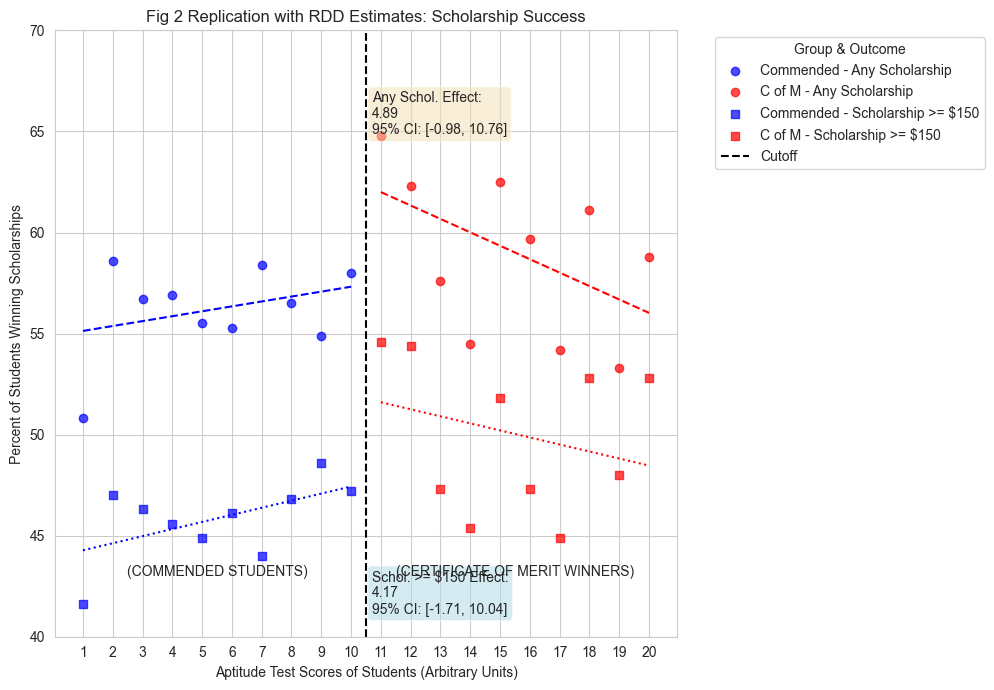

In [6]:
# --- Re-Plot Figure 2 with Annotations ---
plt.figure(figsize=(12, 7))

# Plot raw data points (as before)
plt.scatter(df_control['test_score'], df_control['scholarship'], color='blue', alpha=0.7, label='Commended - Any Scholarship')
plt.scatter(df_treated['test_score'], df_treated['scholarship'], color='red', alpha=0.7, label='C of M - Any Scholarship')
plt.scatter(df_control['test_score'], df_control['scholarship_150'], marker='s', color='blue', alpha=0.7, label='Commended - Scholarship >= $150')
plt.scatter(df_treated['test_score'], df_treated['scholarship_150'], marker='s', color='red', alpha=0.7, label='C of M - Scholarship >= $150')

# Plot regression lines (as before)
plt.plot(df_control['test_score'], df_control['pred_schol'], color='blue', linestyle='--')
plt.plot(df_treated['test_score'], df_treated['pred_schol'], color='red', linestyle='--')
plt.plot(df_control['test_score'], df_control['pred_schol150'], color='blue', linestyle=':')
plt.plot(df_treated['test_score'], df_treated['pred_schol150'], color='red', linestyle=':')

# Add cutoff line
plt.axvline(x=10.5, color='black', linestyle='--', label='Cutoff')

# Add Annotations for RDD results
schol_res = rdd_results['scholarship']
schol150_res = rdd_results['scholarship_150']

# Annotation text - position might need tweaking based on plot
y_pos_schol = 67 # Approximate y position for annotation
y_pos_schol150 = 41

annot_schol = f"Any Schol. Effect:\n{schol_res['estimate']:.2f}\n95% CI: [{schol_res['ci_lower']:.2f}, {schol_res['ci_upper']:.2f}]"
annot_schol150 = f"Schol. >= $150 Effect:\n{schol150_res['estimate']:.2f}\n95% CI: [{schol150_res['ci_lower']:.2f}, {schol150_res['ci_upper']:.2f}]"

plt.text(10.7, y_pos_schol, annot_schol, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))
plt.text(10.7, y_pos_schol150, annot_schol150, verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.3', fc='lightblue', alpha=0.5))


# Labels and Title
plt.xlabel("Aptitude Test Scores of Students (Arbitrary Units)")
plt.ylabel("Percent of Students Winning Scholarships")
plt.title("Fig 2 Replication with RDD Estimates: Scholarship Success")
plt.ylim(40, 70)
plt.xticks(range(1, 21))
plt.legend(title="Group & Outcome", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.text(5.5, 43, "(COMMENDED STUDENTS)", horizontalalignment='center')
plt.text(15.5, 43, "(CERTIFICATE OF MERIT WINNERS)", horizontalalignment='center')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

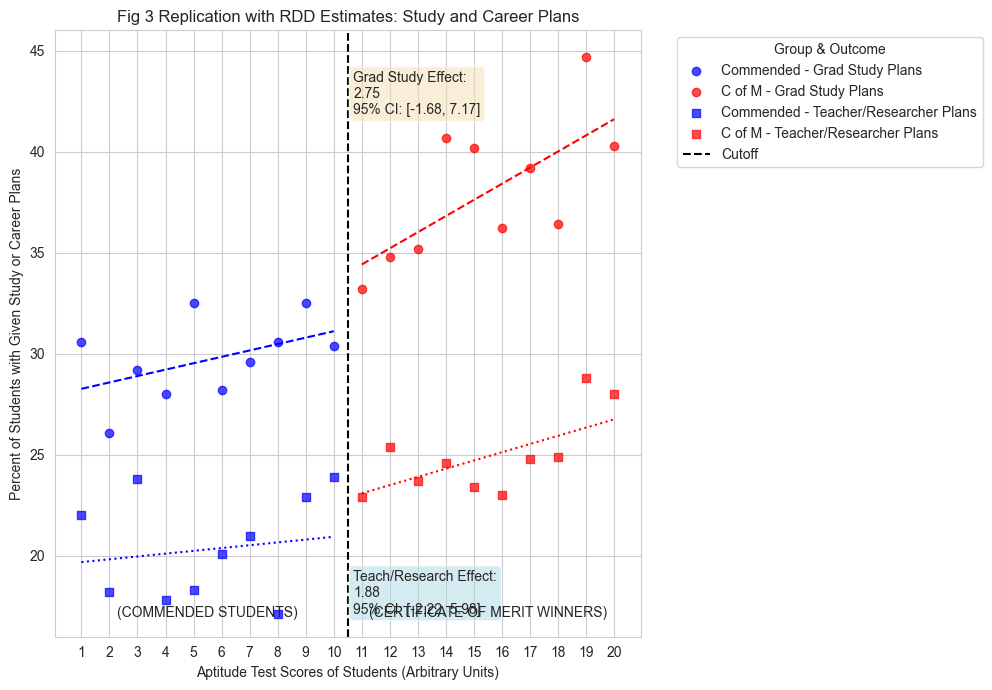

In [7]:
# --- Re-Plot Figure 3 with Annotations ---
plt.figure(figsize=(12, 7))

# Plot raw data points (as before)
plt.scatter(df_control['test_score'], df_control['graduate_study'], color='blue', alpha=0.7, label='Commended - Grad Study Plans')
plt.scatter(df_treated['test_score'], df_treated['graduate_study'], color='red', alpha=0.7, label='C of M - Grad Study Plans')
plt.scatter(df_control['test_score'], df_control['teacher_researcher'], marker='s', color='blue', alpha=0.7, label='Commended - Teacher/Researcher Plans')
plt.scatter(df_treated['test_score'], df_treated['teacher_researcher'], marker='s', color='red', alpha=0.7, label='C of M - Teacher/Researcher Plans')

# Plot regression lines (as before)
plt.plot(df_control['test_score'], df_control['pred_grad'], color='blue', linestyle='--')
plt.plot(df_treated['test_score'], df_treated['pred_grad'], color='red', linestyle='--')
plt.plot(df_control['test_score'], df_control['pred_teach'], color='blue', linestyle=':')
plt.plot(df_treated['test_score'], df_treated['pred_teach'], color='red', linestyle=':')

# Add cutoff line
plt.axvline(x=10.5, color='black', linestyle='--', label='Cutoff')

# Add Annotations for RDD results
grad_res = rdd_results['graduate_study']
teach_res = rdd_results['teacher_researcher']

# Annotation text - position might need tweaking
y_pos_grad = 44 # Approximate y position for annotation
y_pos_teach = 17

annot_grad = f"Grad Study Effect:\n{grad_res['estimate']:.2f}\n95% CI: [{grad_res['ci_lower']:.2f}, {grad_res['ci_upper']:.2f}]"
annot_teach = f"Teach/Research Effect:\n{teach_res['estimate']:.2f}\n95% CI: [{teach_res['ci_lower']:.2f}, {teach_res['ci_upper']:.2f}]"

plt.text(10.7, y_pos_grad, annot_grad, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))
plt.text(10.7, y_pos_teach, annot_teach, verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.3', fc='lightblue', alpha=0.5))


# Labels and Title
plt.xlabel("Aptitude Test Scores of Students (Arbitrary Units)")
plt.ylabel("Percent of Students with Given Study or Career Plans")
plt.title("Fig 3 Replication with RDD Estimates: Study and Career Plans")
plt.ylim(16, 46)
plt.xticks(range(1, 21))
plt.legend(title="Group & Outcome", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.text(5.5, 17, "(COMMENDED STUDENTS)", horizontalalignment='center')
plt.text(15.5, 17, "(CERTIFICATE OF MERIT WINNERS)", horizontalalignment='center')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## Conclusion

This notebook successfully replicated Figures 2 and 3 from Thistlewaite and Campbell (1960) using aggregated data derived from their study. The plots clearly show discontinuities at the cutoff point for the Certificate of Merit award across various outcomes related to scholarships and future academic/career plans.

Furthermore, we extended the original analysis by formally estimating the size of these discontinuities using a weighted local linear regression RDD model. The results provide point estimates and 95% confidence intervals for the causal effect of receiving the Certificate of Merit:

*   **Scholarships:** There are statistically significant positive effects on winning any scholarship and winning scholarships of $150 or more.
*   **Study/Career Plans:** There appear to be smaller, possibly statistically significant positive effects on planning extensive graduate study and planning a career as a teacher or researcher. (Check the p-values and CIs from the RDD estimation block for formal significance).

This exercise demonstrates the power of the RDD methodology introduced by Thistlewaite and Campbell for estimating causal effects in quasi-experimental settings and showcases how modern tools can be used to replicate and extend seminal research.